# Visualization

## Code

In [39]:
import sys
sys.path.insert(0, '/home/emmanuel/projects/2019_rbig_ad/src')
sys.path.append('/home/emmanuel/code/py_esdc')
sys.path.append('/home/emmanuel/code/rbig')


# DataCube PreProcessing
from scipy.io import savemat, loadmat
import geopandas as geopd
from rasterio import features

# Main Libraries
import numpy as np
import scipy.io as scio
import xarray as xr
import pandas as pd
import seaborn as sns
from datetime import date
import time

# IT Algorithms
from rbig import RBIG, RBIGMI

# ML Preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from scipy import signal

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['seaborn-poster'])
import tqdm

# Utilities
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

# Notebook Specifics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
plt.style.available

['seaborn-dark-palette',
 'classic',
 'ggplot',
 'seaborn-dark',
 'seaborn-pastel',
 'seaborn-bright',
 'seaborn-deep',
 'tableau-colorblind10',
 'seaborn-talk',
 'fast',
 'seaborn-ticks',
 'seaborn-white',
 'bmh',
 'fivethirtyeight',
 'seaborn-muted',
 '_classic_test',
 'grayscale',
 'seaborn-darkgrid',
 'seaborn-poster',
 'seaborn',
 'seaborn-whitegrid',
 'dark_background',
 'seaborn-paper',
 'seaborn-colorblind',
 'seaborn-notebook',
 'Solarize_Light2']

In [7]:
FIG_PATH = '/home/emmanuel/projects/2020_rbig_rs/reports/figures/drought/individual/'
DATA_PATH = '/home/emmanuel/projects/2020_rbig_rs/data/drought/results/'

datasets = [
    'exp_trial_v1.csv',
    'group_trial_v1.csv'
]

## Experiment I - Individual Variables

In [14]:
data = pd.read_csv(DATA_PATH + datasets[0], index_col=[0])
data.head()

,dimensions,h,samples,tc,temporal,time,variable
0,1.0,1.405693,25779.0,0.000000,1.0,0.586735,VOD
1,1.0,1.311283,25779.0,0.000000,1.0,0.593768,NDVI
2,1.0,1.141273,25779.0,0.000000,1.0,0.563080,SM
3,1.0,1.364679,25779.0,0.000000,1.0,0.561935,LST
4,2.0,2.680166,24108.0,0.128393,2.0,1.456331,VOD


### Normalize

In [17]:
# normalize
data['h_norm'] = data['h'].div(data.temporal)
data['tc_norm'] = data['tc'].div(data.temporal)

### Entropy

In [40]:
def plot_entropy(data, normalized=False, save=True):
    fig, ax = plt.subplots()
    if normalized:
        y = 'h_norm'
        
    else:
        y = 'h'
    sns.lineplot(
        x="temporal", y=y, 
        hue='variable', 
        data=data,
        marker='o', 
    )
    ax.set_xlabel('Temporal Dims')
    ax.set_ylabel('Entropy')
    # plt.legend(['NDVI', 'LST', 'SM', 'VOD'])
    plt.tight_layout()
    plt.show()
    if normalized and save:
        fig.savefig(f"{FIG_PATH}H_norm_individual.png", frameon=False, )
    elif save:
        fig.savefig(f"{FIG_PATH}H_individual.png", frameon=False, )
    
    

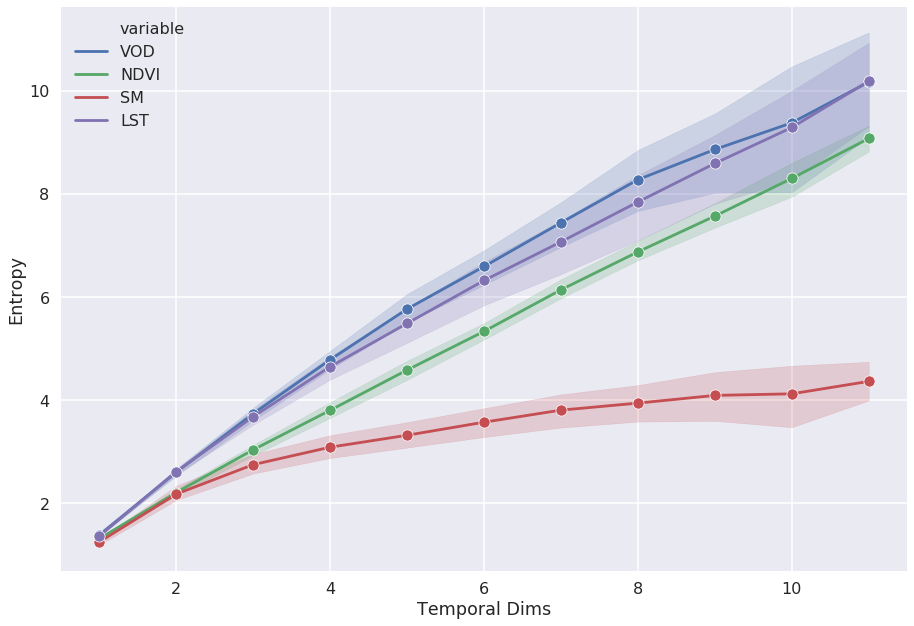

In [41]:
plot_entropy(data, normalized=False, save=False)

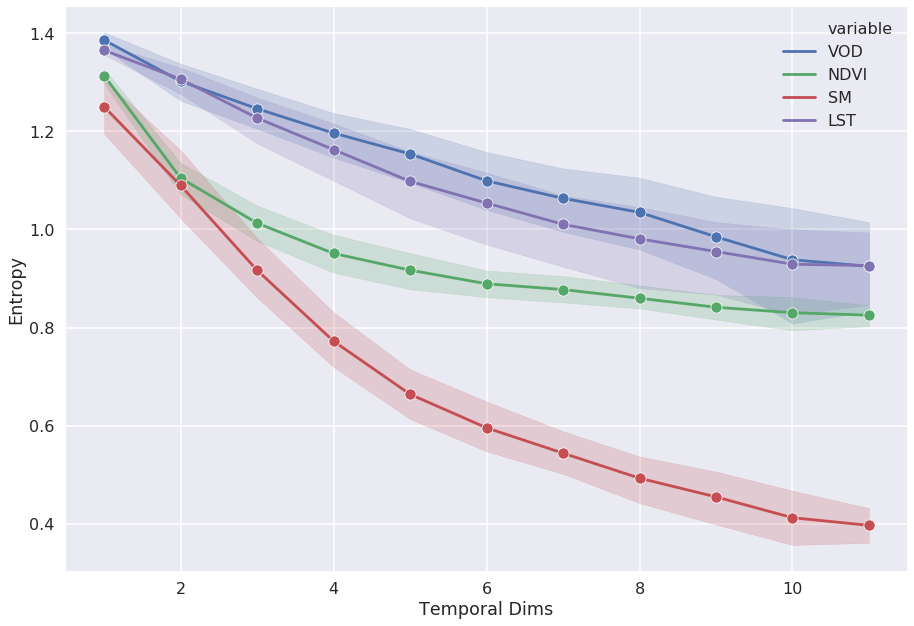

In [42]:
plot_entropy(data, normalized=True, save=False)

### Total Correlation

In [45]:
def plot_tc(data, normalized=False, save=True):
    fig, ax = plt.subplots()
    if normalized:
        y = 'tc_norm'
        
    else:
        y = 'tc'
    sns.lineplot(
        x="temporal", y=y, 
        hue='variable', 
        data=data,
        marker='o', 
    )
    ax.set_xlabel('Temporal Dims')
    ax.set_ylabel('Total Correlation')
    # plt.legend(['NDVI', 'LST', 'SM', 'VOD'])
    plt.tight_layout()
    plt.show()
    if normalized and save:
        fig.savefig(f"{FIG_PATH}TC_norm_individual.png", frameon=False, )
    elif save:
        fig.savefig(f"{FIG_PATH}TC_individual.png", frameon=False, )
    

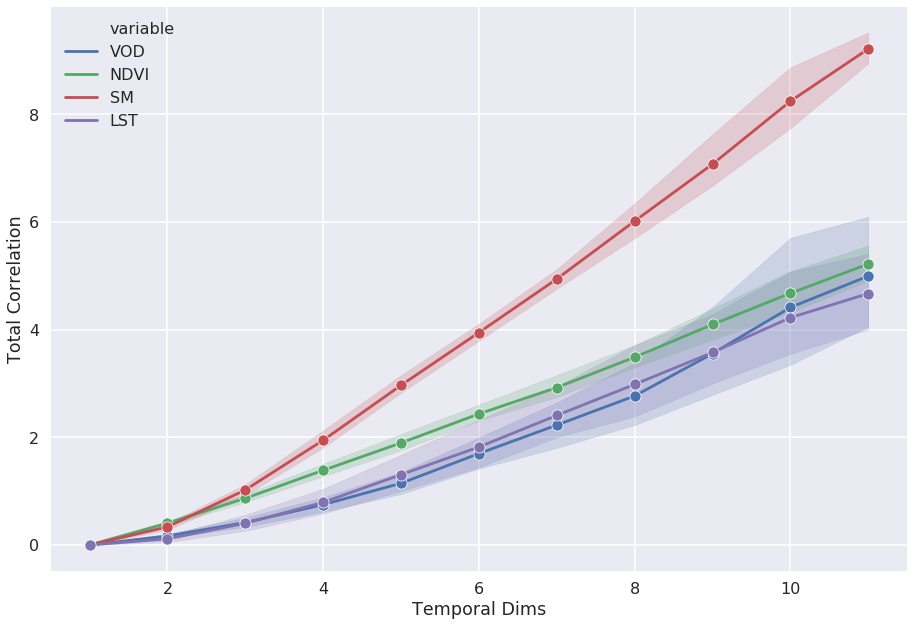

In [46]:
plot_tc(data, normalized=False, save=False)

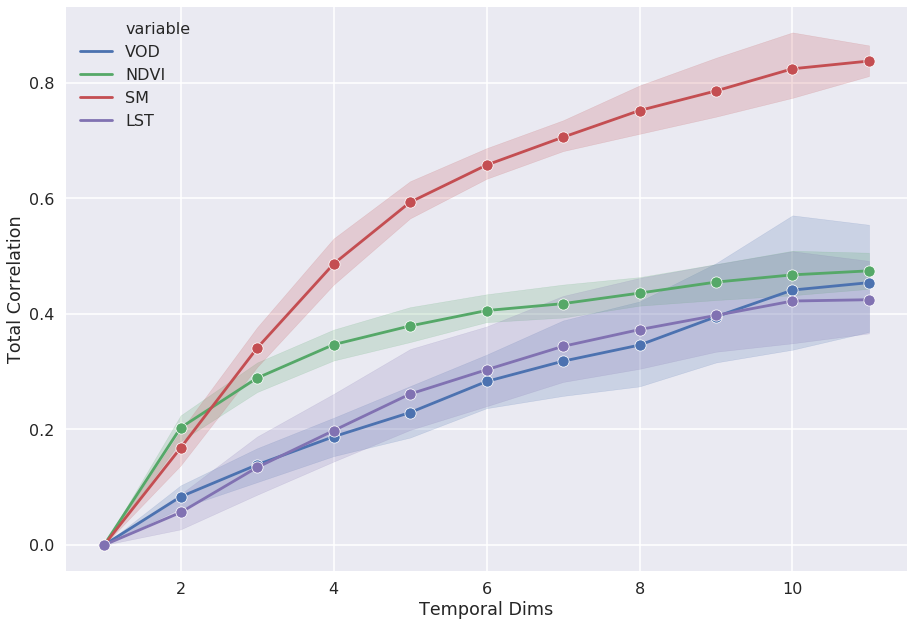

In [47]:
plot_tc(data, normalized=True, save=False)

## Experiment II - Comparing Variables

In [109]:
data_group = pd.read_csv(DATA_PATH + datasets[1], index_col=[0])
data_group.head()

,dimensions,mi,samples,temporal,time,variable1,variable2
0,1.0,0.014735,25779.0,1.0,2.806826,VOD,NDVI
1,1.0,0.024350,25779.0,1.0,2.877755,VOD,LST
2,1.0,0.129068,25779.0,1.0,3.264479,VOD,SM
3,1.0,0.019120,25779.0,1.0,2.830254,NDVI,LST
4,1.0,0.059311,25779.0,1.0,2.828490,NDVI,SM


### Normalize

In [116]:
# normalize
data_group['mi_norm'] = data_group['mi'].div(data_group.temporal)


In [71]:
cond1 = data_group['variable1'] == 'NDVI'
cond2 = data_group['variable2'] == 'NDVI'
data_group.loc[cond1 & cond2, ['variable1', 'variable2']] = data_group.loc[cond1 & cond2, ['variable2', 'variable1']].values

In [141]:
def move_variables(df: pd.DataFrame, variable: str)-> pd.DataFrame:
#     cond1 = df['variable1'] == variable
    cond = df['variable2'] == variable
    df.loc[
        cond, ['variable2', 'variable1']
    ] = df.loc[
        cond, ['variable1', 'variable2']
    ].values

    return df

In [145]:
df_new = move_variables(data_group, 'NDVI')

df_new.head()

,dimensions,mi,samples,temporal,time,variable1,variable2,mi_norm
0,1.0,0.014735,25779.0,1.0,2.806826,NDVI,VOD,0.014735
1,1.0,0.024350,25779.0,1.0,2.877755,VOD,LST,0.024350
2,1.0,0.129068,25779.0,1.0,3.264479,VOD,SM,0.129068
3,1.0,0.019120,25779.0,1.0,2.830254,NDVI,LST,0.019120
4,1.0,0.059311,25779.0,1.0,2.828490,NDVI,SM,0.059311


### Mutual Information

In [147]:
def plot_mutual_info(data, normalized=False, save=True, variable='VOD'):
    fig, ax = plt.subplots()
    
    # Select variable
    data = move_variables(data, variable)
    
    data = data[data['variable1'] == variable]
#     print(data.variable2)
    if normalized:
        y = 'mi_norm'
        
    else:
        y = 'mi'
    sns.lineplot(
        x="temporal", y=y, 
        hue='variable2', 
        data=data,
        marker='o', 
    )
    ax.set_xlabel('Temporal Dims')
    ax.set_ylabel('Mutual Information')
    # plt.legend(['NDVI', 'LST', 'SM', 'VOD'])
    plt.tight_layout()
    plt.show()
    if normalized and save:
        fig.savefig(f"{FIG_PATH}MI_norm_individual.png", frameon=False, )
    elif save:
        fig.savefig(f"{FIG_PATH}MI_individual.png", frameon=False, )

#### VOD

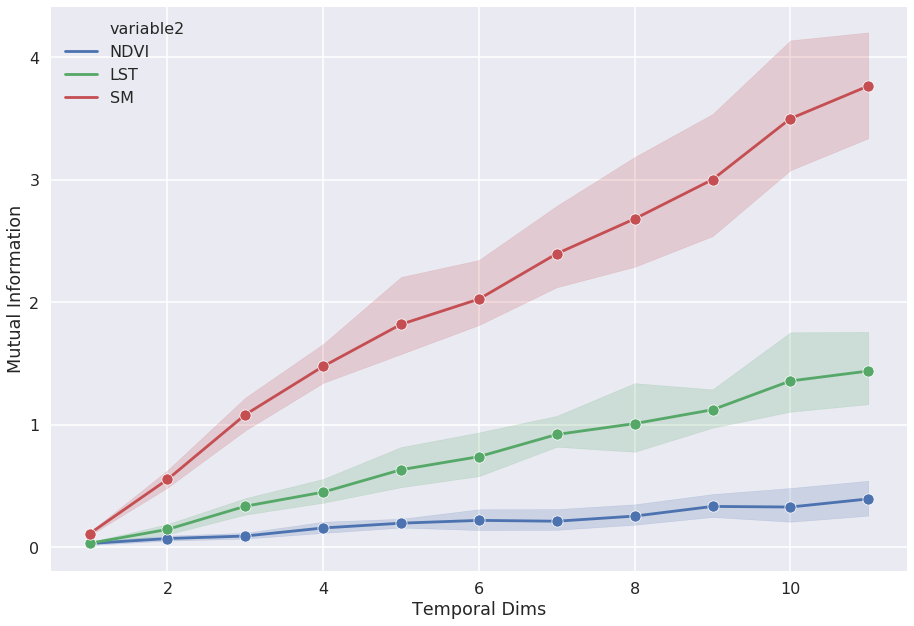

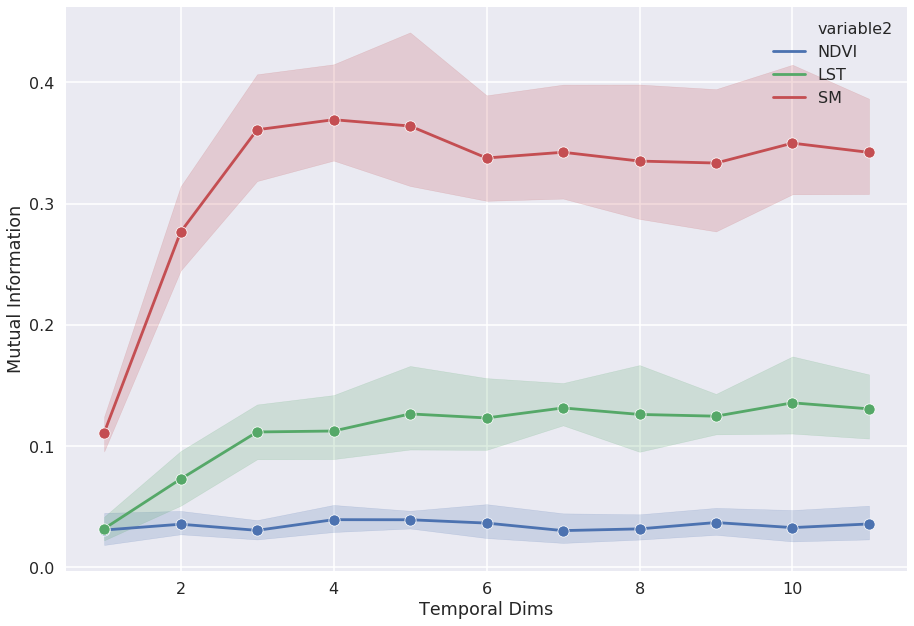

In [153]:
plot_mutual_info(data_group, normalized=False, save=True, variable='VOD')
plot_mutual_info(data_group, normalized=True, save=True, variable='VOD')

#### NDVI

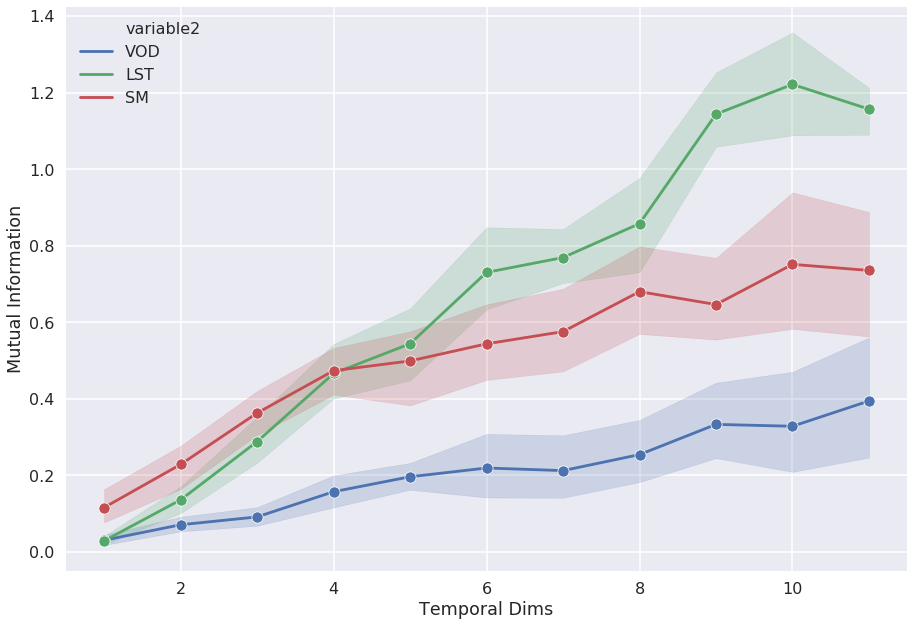

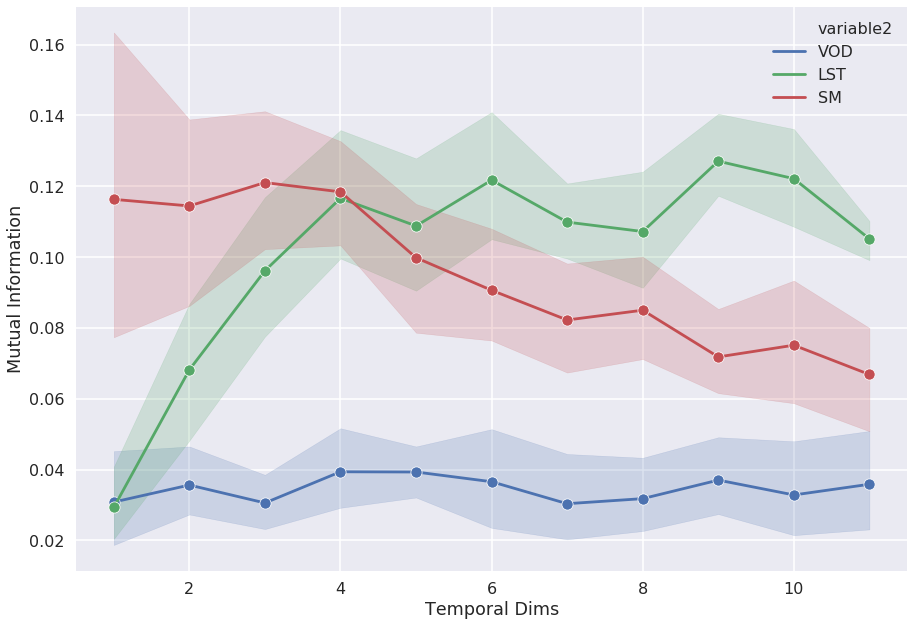

In [154]:
plot_mutual_info(data_group, normalized=False, save=True, variable='NDVI')
plot_mutual_info(data_group, normalized=True, save=True, variable='NDVI')

#### LST

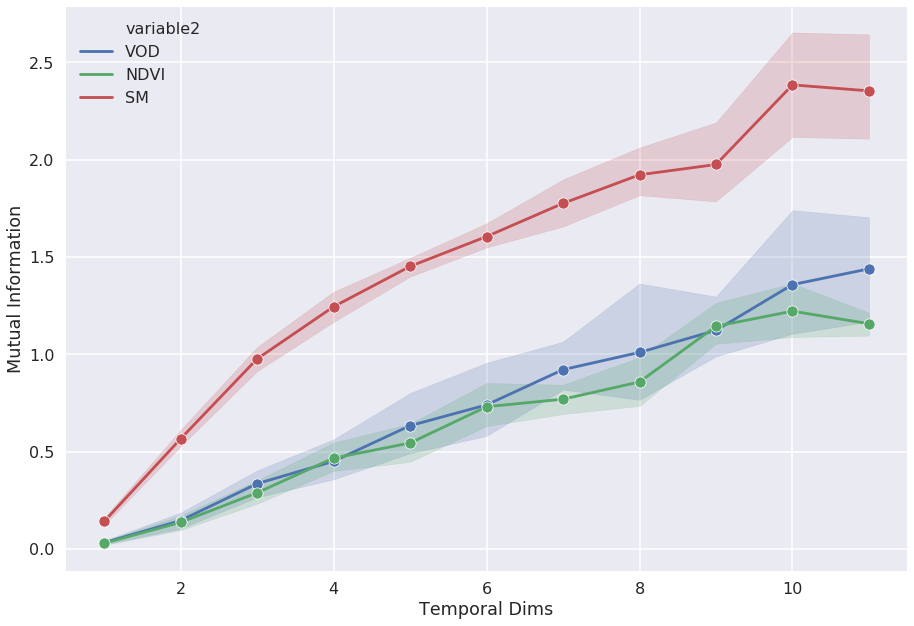

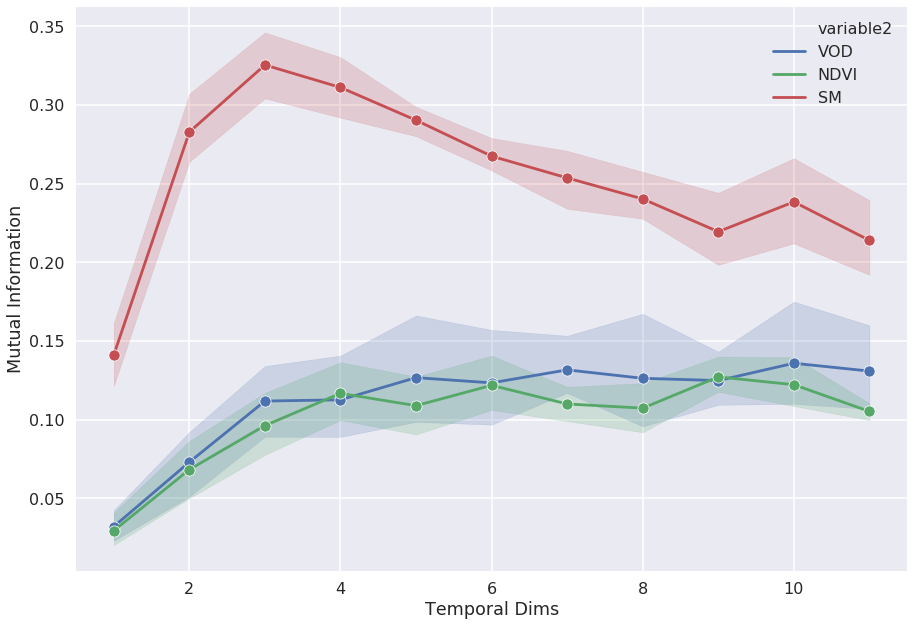

In [155]:
plot_mutual_info(data_group, normalized=False, save=True, variable='LST')
plot_mutual_info(data_group, normalized=True, save=True, variable='LST')

#### SM

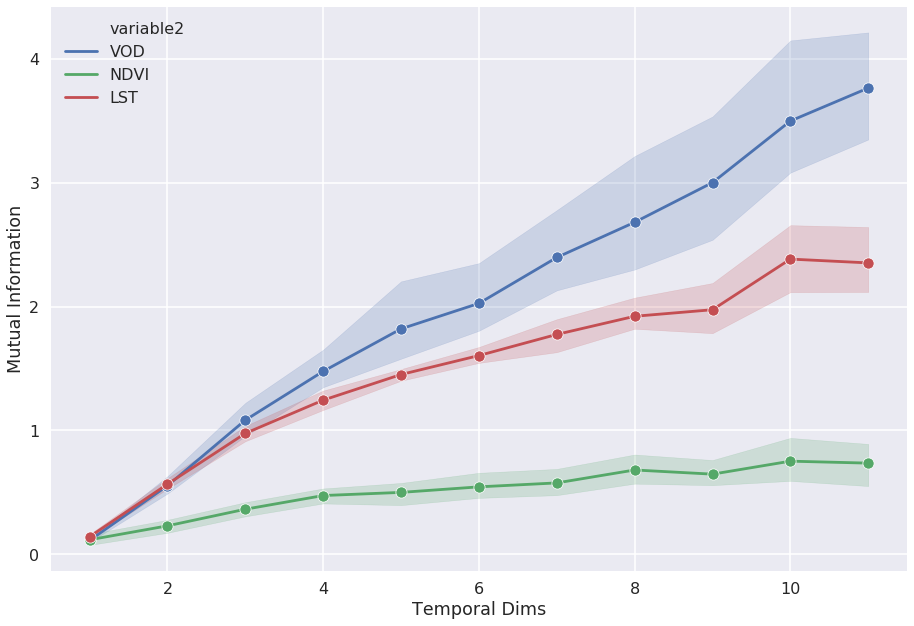

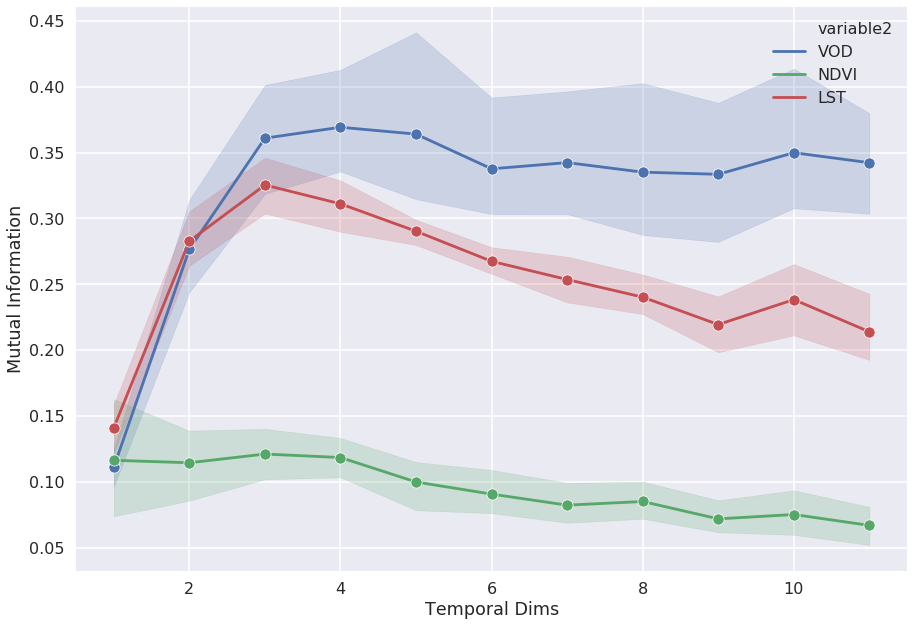

In [156]:
plot_mutual_info(data_group, normalized=False, save=True, variable='SM')
plot_mutual_info(data_group, normalized=True, save=True, variable='SM')